In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from plots import *
from utils import *

# auto reload modules
%load_ext autoreload
%autoreload 2

# set line width
plt.rcParams['lines.linewidth'] = 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Moving Average Strategy

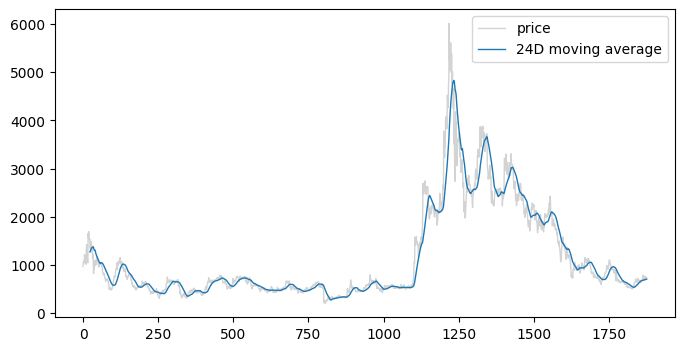

In [68]:
# load data
df = pd.read_csv('mkr_coinmarketcap.csv')
df['ma_24'] = df['usd'].rolling(24).mean()
df['r'] = df['usd'].pct_change()

# plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(df['usd'], label='price', color='lightgray')
ax.plot(df['ma_24'], label='24D moving average')
ax.legend()
plt.show()

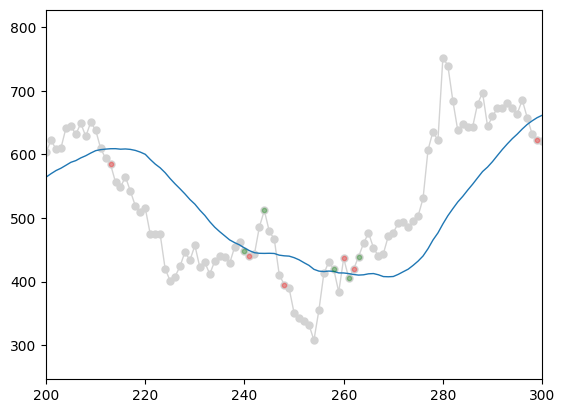

In [57]:
df['enex'] = 0
# loop dataframe
for i in range(24, len(df)):
    if df['usd'][i] > df['ma_24'][i] and df['usd'][i-1] < df['ma_24'][i-1]:
        df.loc[i, 'enex'] = 1
    elif df['usd'][i] < df['ma_24'][i] and df['usd'][i-1] > df['ma_24'][i-1]:
        df.loc[i, 'enex'] = -1

# avoid look ahead bias
df['enex'] = df['enex'].shift(1)

ax = plot_positions(df.usd, df.enex, s=10)
ax.plot(df.ma_24)
T1 = 200
T2 = 300
# set x-limit
ax.set_xlim(T1, T2)
adjust_xy(ax, df.usd, (T1, T2))

How do returns look like if we try shorting using this strategy?

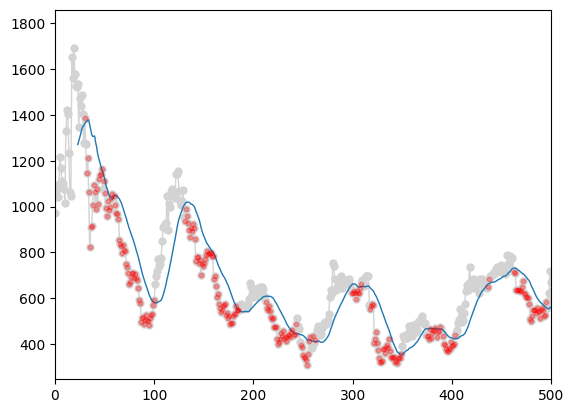

In [58]:
df['positions'] = add_fixed_holding_periods(df.enex)
# select only positions with value = -1
df.loc[df['positions'] != -1, 'positions'] = 0
# plot
ax = plot_positions(df.usd, df.positions, s=10)
ax.plot(df.ma_24)
T1 = 0
T2 = 500
# set x-limit
ax.set_xlim(T1, T2)
adjust_xy(ax, df.usd, (T1, T2))

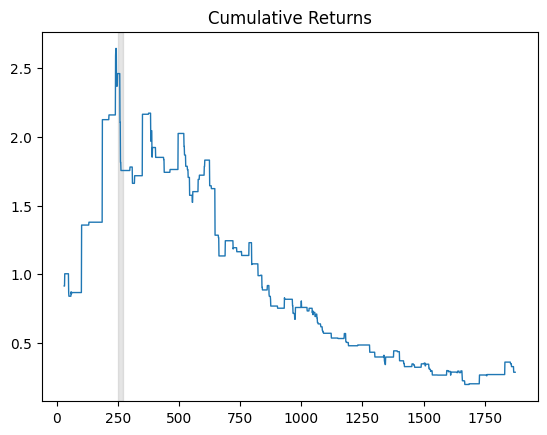

In [65]:
# compute returns
df['strategy_cumr'] = (df['r'] * df['positions'] + 1).cumprod()
cumr = df.strategy_cumr[df.enex != 0]
cumr = cumr.reindex(range(len(df)))
cumr = cumr.fillna(method='ffill')
df['strategy_cumr'] = cumr
# plot
ax = df.strategy_cumr.plot(title='Cumulative Returns')
ax.axvspan(250, 270, alpha=0.2, color='grey')

The strategy loses money. It is due to false positives. We can see an example of this below:

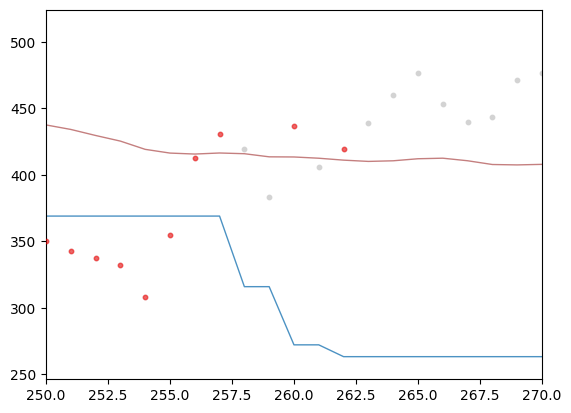

In [64]:
fig, ax = plt.subplots()
ax = plot_positions(df.usd, df.positions, s=10, alpha=0.5, ax = ax, scatter_price=True)
T1 = 250
T2 = 270
adjust_xy(ax, df.usd, (T1, T2))
ax.plot(df.ma_24, c='darkred', alpha=0.5)
ax.plot(df.strategy_cumr*150, alpha=0.8, label='returns')